In [ ]:
# Imports
from IPython.display import clear_output
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import spacy
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Downloading the Spam SMS Dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

!unzip /content/smsspamcollection.zip
!rm /content/readme
!rm !rm /content/smsspamcollection.zip

clear_output()

In [ ]:
!unzip /content/glove.6B.50d.txt.zip

unzip:  cannot find or open /content/glove.6B.50d.txt.zip, /content/glove.6B.50d.txt.zip.zip or /content/glove.6B.50d.txt.zip.ZIP.


In [ ]:
# Downloading the GloVe embeddings database
# 6B implies the size of the vocabulary is 6 billion words (on which it was trained)
# 50d means the dimensionality (size) of each word is 50
!wget https://nlp.stanford.edu/data/glove.6B.zip

!unzip /content/glove.6B.zip

!rm -rf /content/glove.6B.zip
!rm /content/glove.6B.100d.txt
!rm /content/glove.6B.200d.txt
!rm /content/glove.6B.300d.txt

clear_output()

In [ ]:
from google.colab import drive
# Mount(Connects) Google drive to colab
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# giving the file path
file_path = "glove.6B.50d.txt"

# Read/open the text file into a DataFrame with space as the delimiter
df = pd.read_csv(file_path, sep=" ", header=None, quoting=3)

print(df) # Just to keep checking things out


                0         1         2        3         4        5         6   \
0              the  0.418000  0.249680 -0.41242  0.121700  0.34527 -0.044457   
1                ,  0.013441  0.236820 -0.16899  0.409510  0.63812  0.477090   
2                .  0.151640  0.301770 -0.16763  0.176840  0.31719  0.339730   
3               of  0.708530  0.570880 -0.47160  0.180480  0.54449  0.726030   
4               to  0.680470 -0.039263  0.30186 -0.177920  0.42962  0.032246   
...            ...       ...       ...      ...       ...      ...       ...   
399995      chanty  0.232040  0.025672 -0.70699 -0.045465  0.13989 -0.628070   
399996      kronik -0.609210 -0.672180  0.23521 -0.111950 -0.46094 -0.007462   
399997     rolonda -0.511810  0.058706  1.09130 -0.551630 -0.10249 -0.126500   
399998     zsombor -0.758980 -0.474260  0.47370  0.772500 -0.78064  0.232330   
399999  sandberger  0.072617 -0.513930  0.47280 -0.522020 -0.35534  0.346290   

              7         8         9   .

In [ ]:
# giving the file path
file_path = "SMSSpamCollection"

# Read/open the text file into a dataframe with tab as the delimiter
df = pd.read_csv(file_path, sep="\t", header=None, names=["Label", "Text"])

print(df)

     Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [ ]:
# read each line of the text file and create a Pandas Data Frame
# label spam messages as 1 and legit messages as 0

text = [] # Making list called text
label = [] # Making list called label

with open("/content/SMSSpamCollection") as f:

    for line in f:
        parts = line.split('\t')
        label.append(1 if parts[0] == 'spam' else 0)
        text.append(parts[1].strip()) # Labelling data accordingly (by appending)

In [ ]:
# Creating a Dataframe
sms = pd.DataFrame(zip(text, label), columns = ["Text", "Label"])
# zip() pairs the elements from text and label
# columns names then respectively
sms['Text_Length'] = sms['Text'].apply(lambda x: len(x.split()))
# A new column is added that stores the number of words in the text

print(sms) # to check stuff

                                                   Text  Label  Text_Length
0     Go until jurong point, crazy.. Available only ...      0           20
1                         Ok lar... Joking wif u oni...      0            6
2     Free entry in 2 a wkly comp to win FA Cup fina...      1           28
3     U dun say so early hor... U c already then say...      0           11
4     Nah I don't think he goes to usf, he lives aro...      0           13
...                                                 ...    ...          ...
5569  This is the 2nd time we have tried 2 contact u...      1           30
5570               Will ü b going to esplanade fr home?      0            8
5571  Pity, * was in mood for that. So...any other s...      0           10
5572  The guy did some bitching but I acted like i'd...      0           26
5573                         Rofl. Its true to its name      0            6

[5574 rows x 3 columns]


In [ ]:
# Loading a pre-trained English language model named 'en_core_web_sm'
# Is from the spacy library, contains algos for processing English text (like tokenization)
spacy_tokenizer = spacy.load('en_core_web_sm')

# Defining a function that tokenizes a given text
def tokenize (text):

    # Using the re module to replace non-ASCII characters with a space
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Replacing punctuation with empty string (basically removing it)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Converting all text to lower case and tokenizes it
    # Simultaneously adds it to the list called tokens
    tokens = [token.text.lower() for token in spacy_tokenizer(text)]
    return tokens

In [ ]:
# Tokenizing the text sms in the dataframe
sms["Tokenized_Text"] = sms["Text"].apply(tokenize)

print(sms) # To check the tokenization

                                                   Text  Label  Text_Length  \
0     Go until jurong point, crazy.. Available only ...      0           20   
1                         Ok lar... Joking wif u oni...      0            6   
2     Free entry in 2 a wkly comp to win FA Cup fina...      1           28   
3     U dun say so early hor... U c already then say...      0           11   
4     Nah I don't think he goes to usf, he lives aro...      0           13   
...                                                 ...    ...          ...   
5569  This is the 2nd time we have tried 2 contact u...      1           30   
5570               Will ü b going to esplanade fr home?      0            8   
5571  Pity, * was in mood for that. So...any other s...      0           10   
5572  The guy did some bitching but I acted like i'd...      0           26   
5573                         Rofl. Its true to its name      0            6   

                                         Tokenized_

In [ ]:
# Defining a function that loads the glove embeddings from the downloaded file
# And creates a dictionary of the form { word : word embedding}
def load_GloVe_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
# encoding is specified to read the text properly if it contains non-ASCII

     for line in f:
          values = line.split()
          word = values[0]
          word_vector = np.asarray(values[1:], dtype= 'float32')
          embeddings[word] = word_vector
          vocab_size = len(embeddings)
    return embeddings

# word_embeddings stores the glove as a dictionary
word_embeddings = load_GloVe_embeddings("/content/glove.6B.50d.txt")

# print(vocab_size)
# To print the dictionary out
# for key, value in word_embeddings.items():
# print(key, ":", value)

In [ ]:
# Function that converts tokenized text into vectors using the word_embeddings dictionary
# Optional parameters are specified too
def embed_text(tokenized_text, word_embeddings, max_text_length=20, embedding_size = 50):
    embedded_text = []
    for token in tokenized_text:
        if token in word_embeddings:
            embedded_text.append(word_embeddings[token])
        else:
            embedded_text.append(np.zeros(embedding_size))
    return np.array(embedded_text)
    """
        given a sequence of tokens convert them to their word embeddings
    """

In [ ]:
# Adding a column called Embedded_Text that contains the word embeddings
sms["Embedded_Text"] = sms["Tokenized_Text"].apply(lambda x: embed_text(x, word_embeddings))
print(sms)

                                                   Text  Label  Text_Length  \
0     Go until jurong point, crazy.. Available only ...      0           20   
1                         Ok lar... Joking wif u oni...      0            6   
2     Free entry in 2 a wkly comp to win FA Cup fina...      1           28   
3     U dun say so early hor... U c already then say...      0           11   
4     Nah I don't think he goes to usf, he lives aro...      0           13   
...                                                 ...    ...          ...   
5569  This is the 2nd time we have tried 2 contact u...      1           30   
5570               Will ü b going to esplanade fr home?      0            8   
5571  Pity, * was in mood for that. So...any other s...      0           10   
5572  The guy did some bitching but I acted like i'd...      0           26   
5573                         Rofl. Its true to its name      0            6   

                                         Tokenized_

In [ ]:
# Making a custom dataset class called load_dataset which inherits from Dataset
# Dataset is a useful class provided in PyTorch
# Defining the dataset class
class load_dataset(Dataset):
    def __init__(self, X, Y): # Function to initialise an instance of load_dataset
        """
        X: the embeddings of the sentence
        Y: ground truth of the sentence (0- positive, 1- negative)
        """
        self.X = X
        self.y = Y

    def __len__(self): # Finding the length of the dataset (no. of samples)
        return len(self.y)  # Is needed by the DataLoader

    def __getitem__(self, idx): # Indexing the dataset to retrieve individual samples
        return self.X[idx], self.y[idx]  # Takes an index 'idx' and returns the corresponding sample

# DataLoader is a class that works on a DataSet and provides features
# Like Batching, Shuffling and more
# The output size is 2 as its either spam or ham

In [ ]:
# Input tensor x is of size (batch_size, sequence_length, input_size)
# Output tensor out is of shape (batch_size, sequence_length, hidden_size)

# Defining the RNN class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2) # fc = fully connected => Linear layer

    # Forward Propagation
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Passing the input 'x' and the initial hidden state 'h0' through the RNN layer
        out, _ = self.rnn(x, h0)
        # 'out' contains the output features from the RNN  for each time step in the sequence
        # The second output _ (not used) is the hidden state for the last time step

        # Only the last output goes to the fully connected layer
        # : selects all the elements of that dimension, -1 selects the last one
        out = self.fc(out[:, -1, :])
        # Hence the size of tensor out becomes (batch_size, hidden_size)
        return out
        # The fully connected layer maps the hidden state of the last time step
        # to the output size of 2

In [ ]:
# Function that trains the model completely
# train_loader is a data loader that would give batche sof inputs and labels
# model is the nn that will be trained
# criterion is the loss function to be used
# optimizer is the algorithm used (to update model parameters)
# 1 step is the full training of one batch of data

def train_model(num_epochs, train_loader, model, criterion, optimizer):
    total_step = len(train_loader)  # Number of batches in 1 epoch
    train_losses = []  # List to store the training loss for each epoch

    for epoch in range(num_epochs):  # Iterating over all epochs
        epoch_loss = 0  # Initialize epoch loss

        for i, (inputs, labels) in enumerate(train_loader):  # Iterating over each batch
            inputs = inputs.float()
            # To make data into floating point format as needed by nn models in pytorch

            # Forward pass
            outputs = model(inputs)  # Putting input to get outputs
            loss = criterion(outputs, labels)  # Calculating loss by supervised learning

            # Back pass and optimize
            optimizer.zero_grad()  # Setting all grads to 0 to avoid accumulation over batches
            loss.backward()  # Back propagation
            optimizer.step()  # Updating all values

            epoch_loss += loss.item()  # Accumulating the loss for each epoch

            if (i + 1) % 100 == 0:  # Checking the training process every 100 steps
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
                # loss.item() gives the scalar value of the loss tensor
                # It is displayed to 4 decimal places using .4f
                # Note that indexing starts at 0 everywhere

        train_losses.append(epoch_loss / total_step)  # Calculating average loss for each epoch and storing

    return train_losses  # Return the list of training losses


Epoch [1/20], Step [100/140], Loss: 0.3899
Epoch [2/20], Step [100/140], Loss: 0.0631
Epoch [3/20], Step [100/140], Loss: 0.2084
Epoch [4/20], Step [100/140], Loss: 0.1586
Epoch [5/20], Step [100/140], Loss: 0.0582
Epoch [6/20], Step [100/140], Loss: 0.0239
Epoch [7/20], Step [100/140], Loss: 0.0230
Epoch [8/20], Step [100/140], Loss: 0.0403
Epoch [9/20], Step [100/140], Loss: 0.2883
Epoch [10/20], Step [100/140], Loss: 0.1140
Epoch [11/20], Step [100/140], Loss: 0.0889
Epoch [12/20], Step [100/140], Loss: 0.1018
Epoch [13/20], Step [100/140], Loss: 0.0255
Epoch [14/20], Step [100/140], Loss: 0.1457
Epoch [15/20], Step [100/140], Loss: 0.0203
Epoch [16/20], Step [100/140], Loss: 0.0307
Epoch [17/20], Step [100/140], Loss: 0.1592
Epoch [18/20], Step [100/140], Loss: 0.0163
Epoch [19/20], Step [100/140], Loss: 0.0126
Epoch [20/20], Step [100/140], Loss: 0.0998


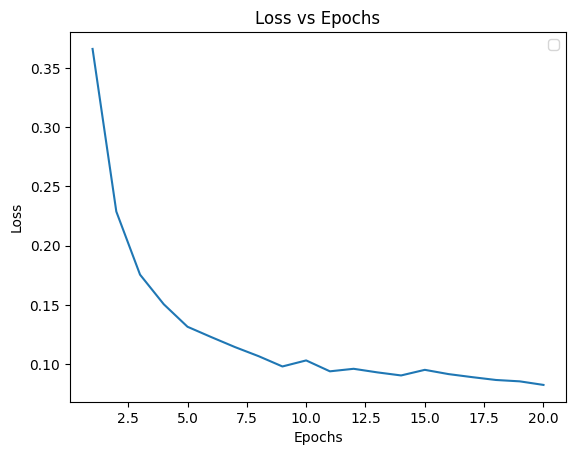

In [20]:
# Function to pad sequences
def pad_sequences(sequences, max_len, embedding_size):
    padded_sequences = []
    for seq in sequences:
        seq_tensor = torch.tensor(seq)
        if len(seq_tensor) < max_len:
            padding = torch.zeros((max_len - len(seq_tensor), embedding_size))
            padded_seq = torch.cat((seq_tensor, padding), dim=0)
        else:
            padded_seq = seq_tensor[:max_len]
        padded_sequences.append(padded_seq)
    return torch.stack(padded_sequences)

# Hyperparameters
input_size = 50
hidden_size = 10
num_layers = 2
learning_rate = 0.001
batch_size = 32
num_epochs = 20
max_len = 25

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(sms["Embedded_Text"].values, sms["Label"].values, test_size=0.2, random_state=42)

# Padding the sequences
X_train_padded = pad_sequences(X_train, max_len, input_size)
X_test_padded = pad_sequences(X_test, max_len, input_size)

# Converting labels to tensors
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

# Create DataLoader objects
train_dataset = load_dataset(X_train_padded, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = RNN(input_size, hidden_size, num_layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # Cross-Entropy is used for classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
train_losses = train_model(num_epochs, train_loader, model, criterion, optimizer)

# Plotting the loss
plt.plot(range(1, num_epochs + 1), train_losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the model as a .pth file
torch.save(model.state_dict(), 'rnn_model.pth')

Accuracy on the test set: 97.04%


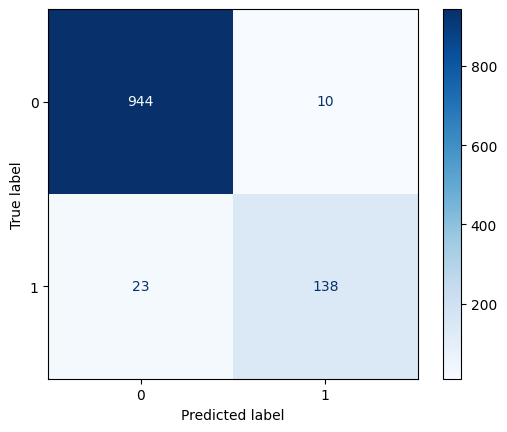

              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.98       954
     Class 1       0.93      0.86      0.89       161

    accuracy                           0.97      1115
   macro avg       0.95      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [21]:
# Function to test the model
def test_model(model, X_test_padded, y_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Convert test data to tensor
        X_test_tensor = torch.tensor(X_test_padded).float()

        # Get model predictions
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate accuracy
        correct = (predicted == y_test_tensor).sum().item()
        accuracy = correct / y_test_tensor.size(0)

        print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

    return predicted

# Test the model
predicted = test_model(model, X_test_padded, y_test_tensor)

# Plotting confusion matrix and other metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.show()

# Print classification report
print(classification_report(y_test_tensor.numpy(), predicted.numpy(), target_names=["Class 0", "Class 1"]))


# Handy Definitions
# epoch = 1 forward and backwartd pass of ALL training samples
# batch_size = number of training samples(sequences) in one forward and backward pass i.e, in one batch
# number of iterations = number of passes, each pass using [batch_size] number of samples
# e.g. 100 samples, batch_size=20 --> 100/20 = 5 iterations for 1 epoch
# sequence_length = The length of each sequence ( number of time steps)
# hidden_size = The number of features in the hidden state of the RNN